# CN-LSTM model that has been designed to predict the temperature of a Home Automation Sensor Netwrok 

In [74]:
#Import the libraries
import math
import os
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import time
import seaborn as sns
import datetime


import keras
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
import graphviz

## Load and perform Data Manupilation

In [489]:
#Load data onto a Data Frame
df = pd.read_csv('temp_data.csv')

In [490]:
#Check the Data
df.head()

,timestamp,Temperature,Battery,Mote,Timestamp,new_date,new_time
0,57:55.0,21.8125,2.977,34,1.589970e+12,20-05-2020,08:57
1,57:14.0,25.6500,3.000,143,1.589970e+12,20-05-2020,08:57
2,57:10.0,21.8125,2.749,38,1.589970e+12,20-05-2020,08:57
3,55:28.0,22.6875,2.937,142,1.589960e+12,20-05-2020,08:55
4,55:02.0,21.3125,2.583,42,1.589960e+12,20-05-2020,08:55


In [491]:
df.shape

(87933, 7)

In [495]:
#Filer for only a particluar Mote and create a dataset
mote = df['Mote']== 142

In [496]:
df2 = df[mote]

In [497]:
df.drop(['new_time'],axis=1,inplace=True)

In [498]:
df2.head()

,timestamp,Temperature,Battery,Mote,Timestamp,new_date,new_time
3,55:28.0,22.6875,2.937,142,1.589960e+12,20-05-2020,08:55
11,50:28.0,22.7500,2.932,142,1.589960e+12,20-05-2020,08:50
18,45:30.0,22.5625,2.937,142,1.589960e+12,20-05-2020,08:45
26,40:28.0,22.6875,2.934,142,1.589960e+12,20-05-2020,08:40
34,35:28.0,22.5625,2.938,142,1.589960e+12,20-05-2020,08:35


In [499]:
#Add the time and date and convert it to Datetime Format
df2["Time"] = df2["new_date"].astype(str)+ ' ' + df2["new_time"].astype(str)
df2['Time'] = pd.to_datetime(df2['Time'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [500]:
df2.head()

,timestamp,Temperature,Battery,Mote,Timestamp,new_date,new_time,Time
3,55:28.0,22.6875,2.937,142,1.589960e+12,20-05-2020,08:55,2020-05-20 08:55:00
11,50:28.0,22.7500,2.932,142,1.589960e+12,20-05-2020,08:50,2020-05-20 08:50:00
18,45:30.0,22.5625,2.937,142,1.589960e+12,20-05-2020,08:45,2020-05-20 08:45:00
26,40:28.0,22.6875,2.934,142,1.589960e+12,20-05-2020,08:40,2020-05-20 08:40:00
34,35:28.0,22.5625,2.938,142,1.589960e+12,20-05-2020,08:35,2020-05-20 08:35:00


In [501]:
#Make theh Index as the Time
df2.set_index(['Time'],inplace=True)

In [502]:
#Remove all columns except the Temperature
df2.drop(['new_date','new_time','timestamp','Timestamp','Battery','Mote'],axis=1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [503]:
df2.head()

,Temperature
Time,
2020-05-20 08:55:00,22.6875
2020-05-20 08:50:00,22.7500
2020-05-20 08:45:00,22.5625
2020-05-20 08:40:00,22.6875
2020-05-20 08:35:00,22.5625


In [504]:
#Resample the data for every 30 minutes in an hour which gives 2 samples for every hours and 48 samples for a day
data = df2.resample(rule='30T', closed='left', label='left', base=5).mean()

In [505]:
data.head()

,Temperature
Time,
2020-01-03 00:05:00,23.604167
2020-01-03 00:35:00,23.625000
2020-01-03 01:05:00,23.734375
2020-01-03 01:35:00,23.666667
2020-01-03 02:05:00,23.520833


In [506]:
data.to_csv('Mote142_hour.csv',index=True)

In [26]:
df = pd.read_csv('Mote142_hour.csv')

In [27]:
df.head()

,Time,Temperature
0,03-01-2020 00:05,23.604167
1,03-01-2020 00:35,23.625000
2,03-01-2020 01:05,23.734375
3,03-01-2020 01:35,23.666667
4,03-01-2020 02:05,23.520833


### Check for null or nan values and replace them with the average of the temperature values

In [29]:
df.set_index(['Time'],inplace=True)

In [30]:
df.isna().sum()

Temperature    12700
dtype: int64

In [31]:
mean = df['Temperature'].mean()

In [32]:
mean

22.825931926929613

In [33]:
df.fillna(df['Temperature'].mean(), inplace=True)

In [34]:
df.isna().sum()

Temperature    0
dtype: int64

In [35]:
df.head()

,Temperature
Time,
03-01-2020 00:05,23.604167
03-01-2020 00:35,23.625000
03-01-2020 01:05,23.734375
03-01-2020 01:35,23.666667
03-01-2020 02:05,23.520833


## Visualize the Data

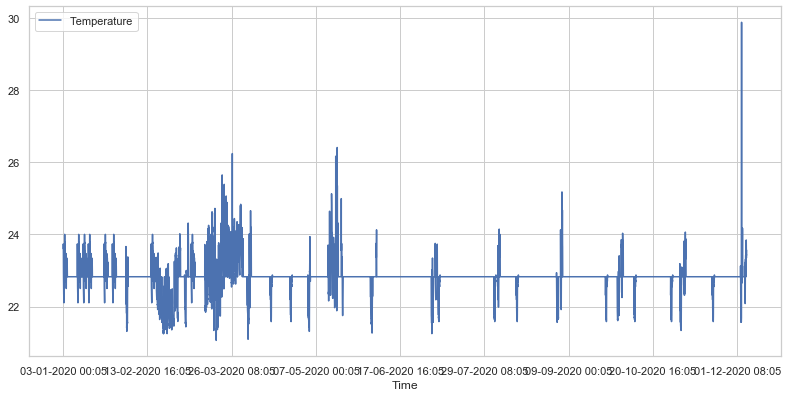

In [43]:
sns.set()
sns.set_style('whitegrid')
df.plot(figsize=(12,6),label='Temperature')
plt.legend()

In [42]:
df.shape

(16224, 1)

## Perpare the Data for the learning

#### This involves scaling the data to a particular range, splitting the data into training and test sets

In [44]:
# Scaling data
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range=(-1,1))
data_scaled = scalar.fit_transform(df)

In [46]:
data_scaled.shape

(16224, 1)

In [47]:
steps = 30
inp = []
out = []
for i in range(len(data_scaled)- (steps)):
    inp.append(data_scaled[i:i+steps])
    out.append(data_scaled[i+steps])

In [48]:
inp=np.asanyarray(inp)
out=np.asanyarray(out)

In [49]:
x_train = inp[:16000,:,:]
x_test = inp[16000:,:,:]    
y_train = out[:16000]    
y_test= out[16000:]

In [52]:
x_test.shape

(194, 30, 1)

## Initialize the CN-LSTM model 

In [103]:
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
early_stop = EarlyStopping(monitor = "loss", mode = "min", patience = 7)
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(30,1)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(30))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Bidirectional(LSTM(128, activation='relu')))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [105]:
history = model.fit(x_train,y_train,epochs=1,verbose=1, callbacks = [early_stop] )

Train on 16000 samples
16000/16000 [==============================] - 145s 9ms/sample - loss: 0.0071


## Calculate the accuracy and predict the values

In [107]:
predict = model.predict(x_test)

In [108]:
predict = scalar.inverse_transform(predict)

In [109]:
Ytesting = scalar.inverse_transform(y_test)

## Plotting the Predicted values against the Test values

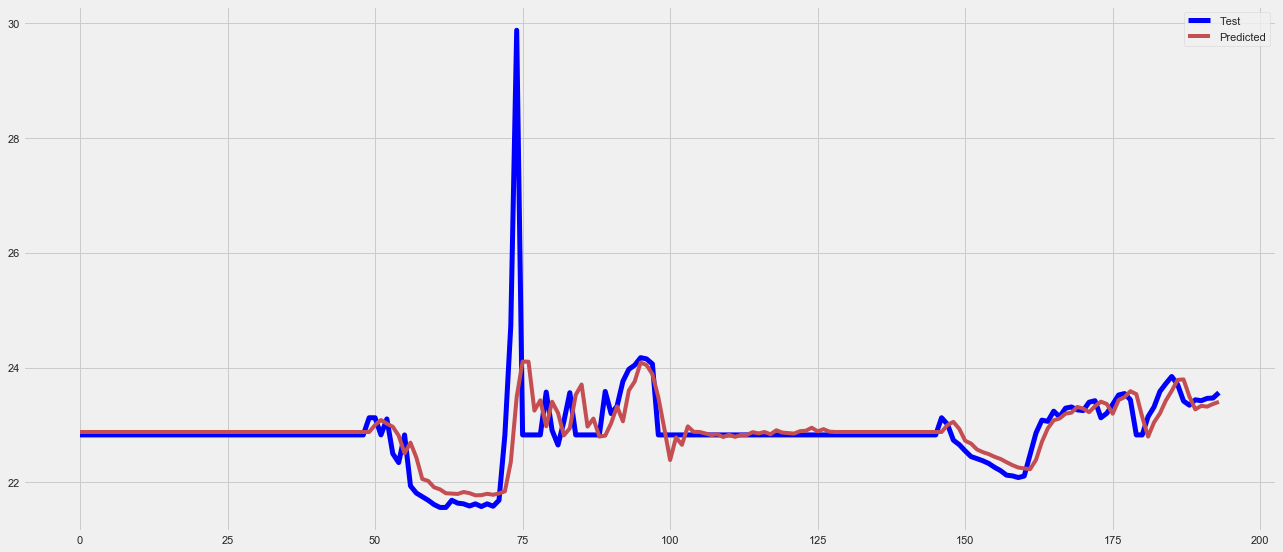

In [110]:
plt.figure(figsize=(20,9))
plt.plot(Ytesting , 'blue', linewidth=5)
plt.plot(predict,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.show()

## Calcuating the Mean Squared Error

In [111]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Ytesting, predict)

0.31591446136456236

## View the Summary of the model

In [112]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 29, 256)           768       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 28, 128)           65664     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 14, 128)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1792)              0         
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 30, 1792)          0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 30, 100)           757200    
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 100)          

## Save the model to a .hdf5 file

In [113]:
model.save("regressor.hdf5")